In [1]:
import os

import h5py
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from scipy.interpolate import UnivariateSpline

from lib.data import raw_io as io
from lib.data import tables as tab
from lib.data import conditions as cond

In [2]:
np.random.seed(42)

In [3]:
engine = tab.sa.create_engine(os.environ['SQLALCHEMY_ENGINE_URL'])
Session = tab.sa.orm.sessionmaker(bind=engine)
session = Session()

In [4]:
average_traces = np.array([
    tr.trace[:420] for tr in 
    session.query(tab.TrialAverageTrace)
        .filter_by(day=7, trial_kind=cond.TrialKind.non_catch)
        .all()
    if not np.all(np.isnan(tr.trace))
])
print(average_traces.shape)

(3339, 420)


In [5]:
average_traces = io.LongFluorescence(
    np.arange(average_traces.shape[0]), 
    np.arange(average_traces.shape[0]), 
    average_traces
)

Text(0.5, 0, 'Time (s)')

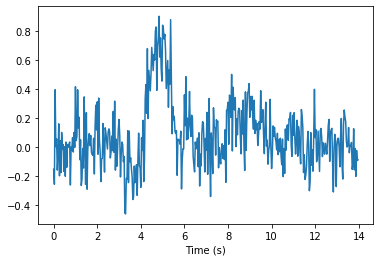

In [9]:
plt.plot(average_traces.time, average_traces.fluo[0, :])
plt.xlabel('Time (s)')

# Aggregate fluorescence 

In [ ]:
pca = PCA(random_state=42)
transformed = pca.fit_transform(average_traces.fluo)

In [ ]:
plt.loglog(pca.explained_variance_ratio_)
plt.ylabel('Fraction of total variance explained')
plt.xlabel('Component no.')

In [ ]:
plt.semilogx(np.cumsum(pca.explained_variance_ratio_))
plt.ylabel('Fraction of total variance explained')
plt.xlabel('Component no.')

The first N components explain this much of the total variance.

In [ ]:
N = 20
print('{:.1f} percent'.format(100 * pca.explained_variance_ratio_[:N].sum()))

In [ ]:
plt.figure(figsize=(8, 4))

ax = plt.subplot(111)
ax.matshow(pca.components_[:N, :], aspect=4)
ax.set_xlabel('Time (frames)')
ax.set_ylabel('Component number')

In [ ]:
plt.axvspan(0, 1, color='gray', label='Tone')
plt.axvline(2.5, color='k', ls='--', label='Reward')

for i in range(4):
    plt.plot(np.arange(pca.components_.shape[1])/30 - 2, pca.components_[i, :], label='Component {}'.format(i))
    
plt.legend(loc='lower right')
plt.xlabel('Time (s)')
plt.ylabel('Fluorescence (AU)')

## Denoising

Reconstruct fluorescence signals using only the top few components.

In [ ]:
reconstructed = np.dot(transformed[:, :N], pca.components_[:N, :])

Compare a few randomly-selected reconstructions.

In [ ]:
for i in np.random.choice(np.arange(0, average_traces.fluo.shape[0]), size=5, replace=False):
    plt.figure(figsize=(8, 4))
    
    plt.subplot(121)
    plt.plot(average_traces.time, average_traces.fluo[i, :], label='Original')
    plt.plot(average_traces.time, reconstructed[i, :], label='Reconstructed')
    plt.xlabel('Time (s)')
    plt.ylabel('Z-score')
    
    plt.subplot(122)
    plt.bar(np.arange(0, N), transformed[i, :N])
    plt.ylabel('Weight')
    plt.xlabel('Component number')
    
    plt.tight_layout()
    plt.show()

In [ ]:
plt.figure(figsize=(6, 8))

ax = plt.subplot(121)
ax.set_title('Original')
ax.imshow(average_traces.fluo, aspect=0.2)
ax.set_ylabel('Cell')

ax_reconstructed = plt.subplot(122)
ax_reconstructed.set_title('Reconstructed from top\n{} components'.format(N))
ax_reconstructed.imshow(reconstructed, aspect=0.2)
ax_reconstructed.set_yticks([])

plt.tight_layout()

plt.show()

# Representation of task structure

...using top components

The top few activity components explored above explain a large majority of Z-scored fluorescence. Next, we want to know how these components can capture trial structure.

In [ ]:
time_from_trial_start = (grand_fluo.time - 2.0)
tone = (time_from_trial_start >= 0.) & (time_from_trial_start < 1.)
delay = (time_from_trial_start >= 1.) & (time_from_trial_start < 2.5)
reward = (time_from_trial_start >= 2.5) & (time_from_trial_start < 2.75)

These are the activity components we'll try to use to capture the trial structure.

In [ ]:
top_components = pca.components_[:N, :].T

In [ ]:
def ols(X, y):
    # TODO add intercept
    XTX = np.dot(X.T, X)
    XTy = np.dot(X.T, y - y.mean())
    coeffs = np.linalg.solve(XTX, XTy)
    return coeffs

In [ ]:
plt.figure(figsize=(8, 4))

plt.subplot(121)
plt.title('True trial structure')
plt.plot(time_from_trial_start, tone, label='Tone')
plt.plot(time_from_trial_start, delay, label='Delay')
plt.plot(time_from_trial_start, reward, label='Reward')
plt.ylabel('AU')
plt.xlabel('Time from tone start (s)')
plt.legend()

plt.subplot(122)
plt.title('Best approximation\nusing top components')
plt.plot(time_from_trial_start, np.dot(top_components, ols(top_components, tone)), label='Tone')
plt.plot(time_from_trial_start, np.dot(top_components, ols(top_components, delay)), label='Delay')
plt.plot(time_from_trial_start, np.dot(top_components, ols(top_components, reward)), label='Reward')
plt.xlabel('Time from tone start (s)')
plt.legend()

plt.show()

## How close does each cell type come to the best case?

In other words, how similar is the activity of each cell to the activity that most accurately reflects a task variable *within principal component space*.

In [ ]:
def cos_similarity(a, b):
    assert np.ndim(a) == 1
    assert np.ndim(b) == 1
    assert len(a) == len(b)
    
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

In [ ]:
def plot_similarities_by_celltype(similarities, cell_types):
    similarities = np.asarray(similarities)
    cell_types = np.asarray(cell_types)
    assert similarities.ndim == 1
    assert cell_types.ndim == 1
    assert len(similarities) == len(cell_types)
    
    plt.figure(figsize=(8, 4))

    ax_hist = plt.subplot(121)
    plt.xlim(-1, 1)
    plt.yticks([])
    plt.xticks([-1, -0.5, 0, 0.5, 1])
    plt.xlabel('Cosine similarity')

    ax_kde = plt.subplot(122)
    plt.xlim(-1, 1)
    plt.xticks([-1, -0.5, 0, 0.5, 1])
    plt.yticks([])
    plt.xlabel('Cosine similarity')

    bins = np.linspace(-1, 1, 30)
    ax_hist.hist(similarities, bins=bins, density=True, label='All cells', color='gray')
    sns.kdeplot(similarities, label='All cells', color='gray', shade=True, ax=ax_kde)

    for cell_type in cond.CellType:
        ax_hist.hist(
            similarities[cell_types == str(cell_type)],
            bins=bins,
            density=True,
            lw=2,
            label=str(cell_type), 
            histtype='step'
        )

        sns.kdeplot(
            similarities[cell_types == str(cell_type)],
            label=str(cell_type)
        )

    ax_hist.legend()
    ax_kde.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
coeffs = ols(top_components, tone)
tone_similarities = np.array([cos_similarity(transformed[i, :N], coeffs) for i in range(transformed.shape[0])])
plot_similarities_by_celltype(tone_similarities, grand_fluo.cell_type)

In [ ]:
coeffs = ols(top_components, delay)
delay_similarities = np.array([cos_similarity(transformed[i, :N], coeffs) for i in range(transformed.shape[0])])
plot_similarities_by_celltype(delay_similarities, grand_fluo.cell_type)

In [ ]:
coeffs = ols(top_components, reward)
reward_similarities = np.array([cos_similarity(transformed[i, :N], coeffs) for i in range(transformed.shape[0])])
plot_similarities_by_celltype(reward_similarities, grand_fluo.cell_type)

### Are the SOM neurons that encode the tone/reward the new ones?

In [ ]:
plt.plot(
    tone_similarities[np.asarray(grand_fluo.cell_type) == str(cond.CellType.som)],
    '.',
    label='Tone'
)
plt.plot(
    delay_similarities[np.asarray(grand_fluo.cell_type) == str(cond.CellType.som)],
    '.',
    label='Delay'
)
plt.plot(
    reward_similarities[np.asarray(grand_fluo.cell_type) == str(cond.CellType.som)],
    '.',
    label='Reward'
)
plt.xlabel('Cell index')
plt.ylabel('Tone similarity')
plt.legend()

In [ ]:
def plot_similarity_by_index(cell_type, smooth=False):
    for sim, label in zip(
        [tone_similarities, delay_similarities, reward_similarities], 
        ['Tone', 'Delay', 'Reward']
    ):
        sim_for_cell_type = sim[np.asarray(grand_fluo.cell_type) == str(cell_type)]
        x = np.arange(0, len(sim_for_cell_type))
        if smooth:
            spline = UnivariateSpline(x, sim_for_cell_type, s=3 * len(x) / 50)
            plt.plot(x, spline(x), '-', label=label)
        else:
            plt.plot(x, sim_for_cell_type, '.', label=label)

    plt.xlabel('Cell index')
    plt.ylabel('Tone similarity')
    plt.legend()

In [ ]:
for cell_type in cond.CellType:
    plt.figure(figsize=(8, 4))
    
    plt.subplot(121)
    plt.title(str(cell_type))
    plot_similarity_by_index(cell_type)
    
    plt.subplot(122)
    plt.title(str(cell_type) + ' smoothed')
    plot_similarity_by_index(cell_type, True)
    
    plt.tight_layout()
    plt.show()

In [ ]:
plt.plot(
    tone_similarities[np.asarray(grand_fluo.cell_type) == str(cond.CellType.som)],
    '.',
    label='Tone'
)
plt.plot(
    delay_similarities[np.asarray(grand_fluo.cell_type) == str(cond.CellType.som)],
    '.',
    label='Delay'
)
plt.plot(
    reward_similarities[np.asarray(grand_fluo.cell_type) == str(cond.CellType.som)],
    '.',
    label='Reward'
)
plt.xlabel('Cell index')
plt.ylabel('Tone similarity')
plt.legend()